# Урок 3
Это часть 2/2: эксперименты.
## План (напоминание)
В этой практической работе мы узнаем новые трюки и попробуем через эксперименты посмотреть, насколько эти трюки хороши.

В первом ноутбуке мы знакомились с Dropout и Batch Normalization слоями.

**Теперь же** мы вернемся к модели классификации изображений из прошлого урока и попробуем ее улучшать.
А именно:
- настроим сохранение метрик в wandb, обучим бейзлайн и сохраним его метрики;
- добьемся воспроизводимости обучения;
- попробуем применить LR Scheduler, сравним метрики;
- попробуем добавить Dropout и Batch Normalization, сравним метрики;

Помимо этого, мы разберем, как не потерять обученную модель.

## Эксперименты: ставим и сравниваем

#### Подключаем wandb к пайплайну обучения

У меня вознакли сложности с работой wandb в облаке из-за санкций США.
wandb можно развернуть локально при наличии проблем с онлайн версией
upd: удалось настроить выгрузку онлайн. Нужно использовать colab и VPN (для доступа к wandb.ai)

Нужно скачать docker image:
> docker pull wandb/local

Затем запустить сервер
> wandb server start
Команда поднимет контейнер с wandb/local и создаст volume для хранения данных

Для остановки сервера:
> wandb server stop

Нужно сгенерировать apikey на локальном сервере

Можно на deploy.wandb.ai сгенерировать бесплатную лицензию и скопировать ее в localhost:8080/system-admin, чтобы не было предупреждения на главном экране

In [1]:
import wandb

# with open("../wandb_apikey") as apikey:
#     key = apikey.read()

# print(key)
# wandb.login(key=key,
#             host="http://localhost:8080",
#             relogin=True)
run = wandb.init(project="project-1")  # БЕЗ entity!
run.log({"metric": 1101})
run.finish()

print("✅ Работает!")

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: a-s-kurdyubov (a-s-kurdyubov-spbu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


metric,▁
metric,1101


✅ Работает!


In [ ]:
# нужно установить библиотеку wandb
import tqdm
import wandb
import time

# затем можно запускать любой код и логгировать любые метрики

def simple_train_loop():
    # Сначала нужно вызвать wandb.init()
    # Это создаст эксперимент в wandb.ai и привяжет его к текущему запуску.
    run = wandb.init(
        # Более детальное описание аргументов: https://docs.wandb.ai/guides/track/launch
        project="wandb-project",
        notes="I created it in my DL course",
        # Можно так же передать config - словарь с любым содержимым.
        # Обычно туда кладут гиперпараметры, настройки обработки данных, random seed и т.д.
        config={"seed": 0, "my-custom_string": "asb"},
    )
    # Теперь запускаем наш код обучения, подготовки данных и т.п. как обычно
    for i in tqdm.trange(300):
        # Имитируем долгое обучение
        time.sleep(0.01)
        # Нужно добавить эту строку, чтобы записать в wandb
        run.log({"iteration": i, "loss": 10 - i ** 0.3})
    # Запуск автоматически завершится, когда скрипт (т.е. ноутбук) завершит работу.
    # Но можно явно завершить:
    run.finish()

# запустим, смотрим
simple_train_loop()

### Готовим пайплайн классификации

Достанем код из прошлого урока, построим модель, добавим в обучение wandb - и убедимся, что все работает.

In [2]:
# А теперь делаем все серьезно.
# Загрузим данные, обучим модель, отрисуем в wandb графики
# Дальше идет код с предыдущей лекции
import http.client
import tarfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def prepare_data():
    """Скачивает данные и распаковывает их."""
    target_file = "notMNIST_small.tar.gz"
    if Path(target_file).exists():
        print("Файл уже загружен, не загружаю снова")
    else:
        conn = http.client.HTTPConnection("yaroslavvb.com", 80)
        conn.request("GET", "/upload/notMNIST/notMNIST_small.tar.gz")
        data = conn.getresponse().read()
        with open(target_file, "wb") as f:
            f.write(data)
    with tarfile.open(target_file) as f:
        f.extractall(filter="data")
    print("Данные были скачены и распакованы")


def read_notmnist_data(
    data_dir: str = "notMNIST_small",
) -> tuple[np.ndarray, np.ndarray]:
    """Прочитать картинки датасета notMNIST и положить их в numpy-массив.

    :returns: пару numpy-массивов (изображения, соответствующие метки)
    """
    images, labels = [], []
    for img_path in Path(data_dir).glob("**/*.png"):
        # Имя папки - это метка класса
        img_label = img_path.parts[1]
        try:
            image = plt.imread(img_path)
        except SyntaxError:
            print(
                f"Изображение не читается по пути {img_path} (это ок, но таких должно быть < 10)"
            )
            continue
        labels.append(img_label)
        images.append(image)
    return np.stack(images, axis=0), np.stack(labels, axis=0)


prepare_data()
X, y = read_notmnist_data()
assert X.shape[0] == y.shape[0]
ohe = LabelEncoder()
y = ohe.fit_transform(y)

Данные были скачены и распакованы
Изображение не читается по пути notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png (это ок, но таких должно быть < 10)
Изображение не читается по пути notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png (это ок, но таких должно быть < 10)


In [3]:
import torch
print(torch.__version__, torch.cuda.is_available())

2.9.0+cu128 True


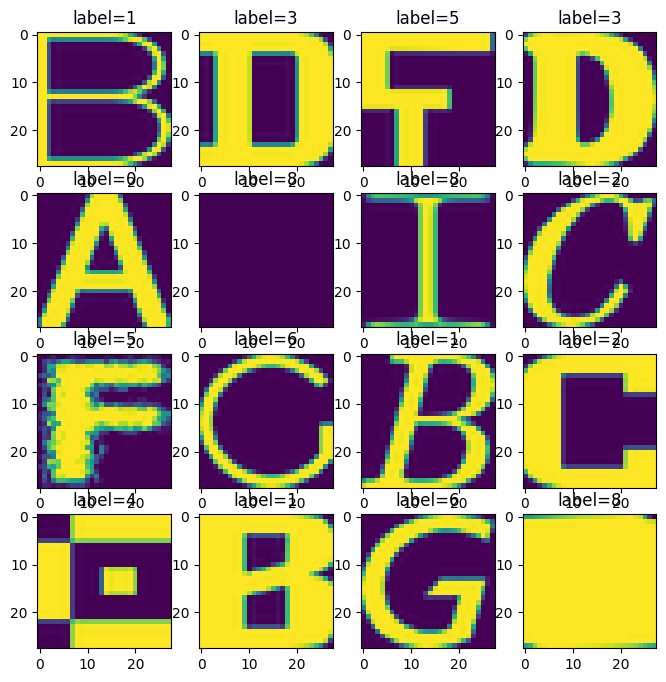

In [4]:
import torch

seed = 0
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=1
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    shuffle=True,
    random_state=1
)
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_val, y_val = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for row in range(4):
    for col in range(4):
        idx = 4 * row + col
        ax[row][col].imshow(X_train[idx])
        ax[row][col].set_title(f"label={y_train[idx]}")
# конец кода с предыдущей лекции
# Перезапустите эту ячейку несколько раз - изображения будут меняться.

In [5]:
import torch.nn as nn


class SimpleModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        hidden_dim = 256
        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x: torch.Tensor):
        x = x.reshape((-1, 28 * 28))
        return self.net(x)

In [ ]:
import torch.nn.functional as F
from torch.optim.sgd import SGD
from dataclasses import dataclass


# конфиги можно сделать в словаре, а можно в датаклассе - будут подсказки в редакторе
@dataclass
class TrainConfig:
    eval_every: int = 10
    lr: float = 1e-2
    total_iterations: int = 3000


def train_loop(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
):
    wandb.init(
        project="simple-model-train",
        notes="version 1",
        tags=["sgd", "2-layer"],
        config=config,
    )

    optim = SGD(model.parameters(), lr=config.lr)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optim.zero_grad()
        loss = F.cross_entropy(model(X_train), y_train)
        loss.backward()
        optim.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}
        # каждые `eval_every` итераций будем считать метрику на отложенной выборке
        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val), y_val)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item()})
        wandb.log(metrics)
    wandb.finish()


torch.random.manual_seed(seed)
config = TrainConfig(eval_every=20, lr=1e-1, total_iterations=500)
model = SimpleModel(num_classes=len(ohe.classes_))
train_loop(model, X_train, y_train, X_val, y_val, config=config)

KeyboardInterrupt: 

In [9]:
import torch.nn.functional as F
from torch.optim.sgd import SGD
from dataclasses import dataclass
import tqdm

# попробуем то же самое на GPU

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

@dataclass
class TrainConfig:
    eval_every: int = 10
    lr: float = 1e-2
    total_iterations: int = 3000

def train_loop_device(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
):
    wandb.init(
        project="simple-model-train",
        notes="version 1",
        tags=["sgd", "2-layer"],
        config=config,
    )

    X_val_dev = X_val.clone().to(device)
    y_val_dev = y_val.clone().to(device)

    optim = SGD(model.parameters(), lr=config.lr)
    # Перенесем на GPU если возможно
    model = model.to(device)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optim.zero_grad()

        X_train_dev = X_train.clone().to(device)
        y_train_dev = y_train.clone().to(device)

        loss = F.cross_entropy(model(X_train_dev), y_train_dev)
        loss.backward()
        optim.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}
        # каждые `eval_every` итераций будем считать метрику на отложенной выборке
        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val_dev), y_val_dev)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item()})
        wandb.log(metrics)
    wandb.finish()


torch.random.manual_seed(seed)
config = TrainConfig(eval_every=20, lr=1e-1, total_iterations=500)
model = SimpleModel(num_classes=len(ohe.classes_))
train_loop_device(model, X_train, y_train, X_val, y_val, config=config)

Используем cuda


100%|██████████| 500/500 [00:17<00:00, 29.27it/s]


iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
loss_train,█████▇▆▆▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,██▇▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,1.60727
loss_val,1.61683


Если перезапустить ноутбук, то графики получатся другие.

Но как же так, мы ничего не меняли в коде?

## Добиваемся воспроизводимости
Пройдемся по ноутбуку и найдем все места, где есть случайности:
- разбиение на train/val/test - это видно по `shuffle=True`;
- инициализация весов модели - веса всех слоев генерируются из случайного распределения;
- могут быть алгоритмы внутри слоев, но у нас таких нету.

Чтобы добиться воспроизводимости, нужно:
1. Добавить `random_state=...` в `train_test_split` - он умеет принимать такой параметр.
2. Зафиксировать `seed` у PyTorch **перед** созданием модели через `torch.random.manual_seed`.

Идем и исправляем это, после чего перезапускаем ячейки.
Теперь графики перестали меняться от запуска к запуску.

## Пробуем новые подходы

### Добавляем LR Scheduler и Adam
Добавим шедулер, его настройки в конфиг, а также переберем несколько вариантов.

Аналогично сделаем для оптимайзера: будем пробовать Adam и SGD.

In [10]:
import typing as tp

from torch.optim.lr_scheduler import ExponentialLR, LinearLR, StepLR
from torch.optim.adam import Adam


# конфиги можно сделать в словаре, а можно в датаклассе - будут подсказки в редакторе
@dataclass
class TrainConfig:
    eval_every: int = 10
    lr: float = 1e-2
    total_iterations: int = 3000
    scheduler_type: tp.Literal["exp", "linear", "step"] | None = None
    optimizer_type: tp.Literal["sgd", "adam"] = "sgd"


def train_loop(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
    run_name: str | None = None,
):
    wandb.init(
        project="simple-model-train",
        notes="version 1",
        # еще добавим возможность называть запуски
        name=run_name,
        tags=[config.optimizer_type, str(config.scheduler_type)],
        config=config,
    )

    #### Новое: создаем разный optimizer в зависимости от конфига ####
    if config.optimizer_type == "sgd":
        optim = SGD(model.parameters(), lr=config.lr)
    else:
        optim = Adam(model.parameters(), lr=config.lr)
    #### Новое: создаем шедулер ####
    # LR scheduler на вход принимает optimizer и некоторые параметры (которые зависят от его алгоритма)
    if config.scheduler_type == "exp":
        scheduler = ExponentialLR(optim, gamma=0.99)
    elif config.scheduler_type == "linear":
        scheduler = LinearLR(
            optim, start_factor=1.0, end_factor=0.1, total_iters=config.total_iterations
        )
    elif config.scheduler_type == "step":
        scheduler = StepLR(optim, step_size=10, gamma=0.9)
    else:
        scheduler = None
    #####

    model.train()
    for i in tqdm.trange(config.total_iterations):
        optim.zero_grad()
        loss = F.cross_entropy(model(X_train), y_train)
        loss.backward()
        optim.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}
        # каждые `eval_every` итераций будем считать метрику на отложенной выборке
        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val), y_val)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item()})
        if scheduler is not None:
            # для scheduler точно так же надо звать .step(), но после обучения и валидации
            # см. пример в документации: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
            scheduler.step()
            metrics.update({"lr": scheduler.get_last_lr()[0]})
        else:
            # Чтобы иметь одинаковый набор графиков
            metrics.update({"lr": config.lr})
        wandb.log(metrics)
    wandb.finish()
    return optim


# на exp быстрее к нулю сойдемся, без scheduler тогда ок.
for optim in ("sgd", "adam"):
    for scheduler_type in (None, "exp", "linear", "step"):
        torch.random.manual_seed(seed)
        config = TrainConfig(
            eval_every=20,
            lr=2,
            total_iterations=500,
            scheduler_type=scheduler_type,
            optimizer_type=optim,
        )
        model = SimpleModel(num_classes=len(ohe.classes_))
        train_loop(
            model,
            X_train,
            y_train,
            X_val,
            y_val,
            config=config,
            run_name=f"optim={optim}__lr_sched={scheduler_type}",
        )

 13%|█▎        | 67/500 [00:07<00:50,  8.62it/s]


KeyboardInterrupt: 

In [ ]:
# Попробуем то же самое на GPU

In [11]:
import typing as tp

from torch.optim.lr_scheduler import ExponentialLR, LinearLR, StepLR
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

# конфиги можно сделать в словаре, а можно в датаклассе - будут подсказки в редакторе
@dataclass
class TrainConfig:
    eval_every: int = 10
    lr: float = 1e-2
    total_iterations: int = 3000
    scheduler_type: tp.Literal["exp", "linear", "step"] | None = None
    optimizer_type: tp.Literal["sgd", "adam"] = "sgd"


def train_loop_dev(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
    run_name: str | None = None,
):
    wandb.init(
        project="simple-model-train",
        notes="version 1",
        # еще добавим возможность называть запуски
        name=run_name,
        tags=[config.optimizer_type, str(config.scheduler_type)],
        config=config,
    )

    X_val_dev = X_val.clone().to(device)
    y_val_dev = y_val.clone().to(device)

    #### Новое: создаем разный optimizer в зависимости от конфига ####
    if config.optimizer_type == "sgd":
        optim = SGD(model.parameters(), lr=config.lr)
    else:
        optim = Adam(model.parameters(), lr=config.lr)
    #### Новое: создаем шедулер ####
    # LR scheduler на вход принимает optimizer и некоторые параметры (которые зависят от его алгоритма)
    if config.scheduler_type == "exp":
        scheduler = ExponentialLR(optim, gamma=0.99)
    elif config.scheduler_type == "linear":
        scheduler = LinearLR(
            optim, start_factor=1.0, end_factor=0.1, total_iters=config.total_iterations
        )
    elif config.scheduler_type == "step":
        scheduler = StepLR(optim, step_size=10, gamma=0.9)
    else:
        scheduler = None
    #####

    model = model.to(device)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optim.zero_grad()

        X_train_dev = X_train.clone().to(device)
        y_train_dev = y_train.clone().to(device)      
        
        loss = F.cross_entropy(model(X_train_dev), y_train_dev)
        loss.backward()
        optim.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}
        # каждые `eval_every` итераций будем считать метрику на отложенной выборке
        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val_dev), y_val_dev)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item()})
        if scheduler is not None:
            # для scheduler точно так же надо звать .step(), но после обучения и валидации
            # см. пример в документации: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
            scheduler.step()
            metrics.update({"lr": scheduler.get_last_lr()[0]})
        else:
            # Чтобы иметь одинаковый набор графиков
            metrics.update({"lr": config.lr})
        wandb.log(metrics)
    wandb.finish()
    return optim


# на exp быстрее к нулю сойдемся, без scheduler тогда ок.
for optim in ("sgd", "adam"):
    for scheduler_type in (None, "exp", "linear", "step"):
        torch.random.manual_seed(seed)
        config = TrainConfig(
            eval_every=20,
            lr=2,
            total_iterations=500,
            scheduler_type=scheduler_type,
            optimizer_type=optim,
        )
        model = SimpleModel(num_classes=len(ohe.classes_))
        train_loop_dev(
            model,
            X_train,
            y_train,
            X_val,
            y_val,
            config=config,
            run_name=f"optim={optim}__lr_sched={scheduler_type}",
        )

Используем cuda


iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
loss_train,███▇▇▇▇▆▅▅▅▅▄▄▄▃▄▄▄▄▂▃▃▃▃▂▂▂▃▃▂▂▂▂▁▁▁▁▁▂
loss_val,█▃▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,66
loss_train,1.78646
loss_val,1.68024
lr,2


100%|██████████| 500/500 [00:16<00:00, 30.23it/s]


iteration,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
loss_train,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,1.52818
loss_val,1.56004
lr,2


100%|██████████| 500/500 [00:16<00:00, 30.12it/s]


iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇███
loss_train,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,1.566
loss_val,1.5811
lr,0.01314


100%|██████████| 500/500 [00:16<00:00, 30.22it/s]


iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█████
loss_train,███▇▅▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
iteration,499
loss_train,1.54036
loss_val,1.56607
lr,0.2


100%|██████████| 500/500 [00:16<00:00, 30.10it/s]


iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
loss_train,█▆▅▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██▇▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,1.56724
loss_val,1.58187
lr,0.01031


100%|██████████| 500/500 [00:16<00:00, 30.04it/s]


iteration,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
loss_train,▁▅██████████████████████████████████████
loss_val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,2.36101
loss_val,2.36202
lr,2


100%|██████████| 500/500 [00:16<00:00, 29.86it/s]


iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
loss_train,▁███▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
loss_val,▁▁███████████████████████
lr,█▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,2.35867
loss_val,2.36602
lr,0.01314


100%|██████████| 500/500 [00:16<00:00, 29.64it/s]


iteration,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
loss_train,▁▄▄▄▄▇██████████████████████████████████
loss_val,▁▁▁▃█████████████████████
lr,███▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▂▂▂▂▂▂▁▁
iteration,499
loss_train,2.36101
loss_val,2.36202
lr,0.2


100%|██████████| 500/500 [00:17<00:00, 29.13it/s]


iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
loss_train,▁███████████████████████████████████████
loss_val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██▇▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,2.36101
loss_val,2.36202
lr,0.01031


#### Что изменил LR Scheduler
Добавление экспоненциального шедулера помогло в начале, но в конце привело к худшей метрике,
чем полное отсутствие шедулера.

Делаем вывод, что LR scheduler не всегда дает пользу.

В больших сетях без него не обойтись, поскольку большие нейросети бывают капризными к выбору learning rate.
Наша же сеть простая, поэтому для нее не имеет разницы - что есть шедулер, что его нет.

#### Что изменил другой оптимайзер
Смена SGD на Adam привела к ухудшению результата модели.
Делаем вывод, что менять оптимайзер - не самая лучшая идея, если хотим выбить больше качества.

Но если модель не хочет учиться, то смена оптимайзера может спасти дело.
Такое случается в больших моделях.


### Добавляем Dropout и Batch Normalization

In [12]:
class DropoutModel(nn.Module):
    def __init__(self, num_classes: int, p_dropout: float = 0.5):
        super().__init__()
        hidden_dim = 256
        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x: torch.Tensor):
        x = x.reshape((-1, 28 * 28))
        return self.net(x)


torch.random.manual_seed(seed)
config = TrainConfig(
    eval_every=20,
    lr=2,
    total_iterations=500,
    # возьмем None как самый лучший вариант
    scheduler_type=None,
    optimizer_type='sgd',
)
model = DropoutModel(num_classes=len(ohe.classes_))
# Запустим версию на GPU
train_loop_dev(model, X_train, y_train, X_val, y_val, config=config, run_name="add-dropout")

100%|██████████| 500/500 [00:17<00:00, 28.49it/s]


iteration,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
loss_train,██▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,1.53591
loss_val,1.55873
lr,2


SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 2
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Лосс на трейне оказался чуть больше, но зато на валидации ошибка оказалась чуть-чуть получше.
Это ожидаемо: dropout нацелен на то, чтобы бороться с переобучением.
Dropout ставит палки в колеса модели, отсюда и увеличенный лосс на трейне.

In [15]:
class BatchNormModel(nn.Module):
    def __init__(self, num_classes: int, p_dropout: float = 0.5):
        super().__init__()
        hidden_dim = 256
        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x: torch.Tensor):
        x = x.reshape((-1, 28 * 28))
        return self.net(x)


torch.random.manual_seed(seed)
config = TrainConfig(
    eval_every=20,
    lr=2,
    total_iterations=500,
    scheduler_type=None,
    optimizer_type="sgd",
)
model = BatchNormModel(num_classes=len(ohe.classes_))
optim = train_loop_dev(
    model, X_train, y_train, X_val, y_val, config=config, run_name="add-batchnorm_sgd"
)

100%|██████████| 500/500 [00:16<00:00, 29.49it/s]


iteration,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
loss_train,█▇▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▂▁▁▁▁▁▁▁▁▁
loss_val,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,499
loss_train,1.48263
loss_val,1.55251
lr,2


Лосс упал и на трейне, и на валидации.

Получается, нормализация выходов слоев действительно помогает выбивать лучшие результаты.

## Как сохранить обученную модель

Отлично, у нас есть улучшение бейзлайна - это SGD + BatchNormalization.

Мы даже его уже обучили!
Можем ли мы как-то сделать так, чтобы при следующем запуске не надо было заново учить? Да, можем.

In [16]:
# Все состояние модели хранится в .state_dict() - словаре из тензоров
model.state_dict()

OrderedDict([('net.0.weight',
              tensor([[-0.0048,  0.0298, -0.0171,  ...,  0.0227,  0.0014,  0.0057],
                      [-0.0114, -0.0004, -0.0017,  ..., -0.0372, -0.0234, -0.0463],
                      [-0.0240,  0.0001, -0.0411,  ...,  0.0103,  0.0260,  0.0252],
                      ...,
                      [-0.0044, -0.0251,  0.0392,  ..., -0.0280,  0.0162, -0.0276],
                      [-0.0172, -0.0041, -0.0052,  ..., -0.0331,  0.0040,  0.0228],
                      [-0.0089,  0.0396,  0.0300,  ..., -0.0265, -0.0699, -0.0480]],
                     device='cuda:0')),
             ('net.0.bias',
              tensor([-0.0347,  0.0165, -0.0140, -0.0505, -0.0128,  0.0301,  0.0191,  0.0237,
                      -0.0299, -0.0174, -0.0108,  0.0385, -0.0141, -0.0147,  0.0342, -0.0275,
                       0.0075, -0.0045,  0.0220, -0.0284, -0.0117, -0.0104, -0.0341, -0.0101,
                       0.0302, -0.0461,  0.0100,  0.0442, -0.0148,  0.0521, -0.0268,  0.

In [17]:
# Это состояние можно сохранить на диск через torch.save

# Обычно файлы pytorch сохраняют с расширением .pt (это не жесткое правило, скорее для понимания)
torch.save(model.state_dict(), "model_3-NOTMNIST-batchnorm.pt")

In [19]:
# и потом можно загрузить

# сохраняются веса, но не объект модели - поэтому его надо создать заново
model_loaded = DropoutModel(num_classes=len(ohe.classes_))
# грузим файл, затем просим pytorch восстановить state_dict из заданного словаря
model_loaded.load_state_dict(torch.load("model_3-NOTMNIST-batchnorm.pt"))
# о нет, не получилось.

RuntimeError: Error(s) in loading state_dict for DropoutModel:
	Unexpected key(s) in state_dict: "net.2.weight", "net.2.bias", "net.2.running_mean", "net.2.running_var", "net.2.num_batches_tracked". 

In [20]:
# Если какие-то ключи не нашлись в файле или лишние, pytorch не даст загрузить.
# Смотрим выше и понимаем, что модель была BatchNormModel - там другой слой.
model_loaded = BatchNormModel(num_classes=len(ohe.classes_))
model_loaded.load_state_dict(torch.load("model_3-NOTMNIST-batchnorm.pt"))

<All keys matched successfully>

In [33]:
# Теперь все ок.
# Проверим, что веса прогрузились те же, что и были
from torch.testing import assert_close

# print(X_train.device, model_loaded(X_train).device, model.cpu()(X_train))
assert_close(model_loaded.cpu()(X_train), model.cpu()(X_train))

### Пара слов про optimizer
Когда мы учим модель, оптимизатор тоже может хранить какие-то тензоры.

Например, Adam хранит скользящее среднее и дисперсию по всем увиденным данным.

Поэтому вместе с моделью надо сохранять и оптимизатор. Делается это точно так же, как с моделями.

In [34]:
optim = Adam(model_loaded.parameters())
optim.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'decoupled_weight_decay': False,
   'params': [0, 1, 2, 3, 4, 5]}]}

In [35]:
torch.save(optim.state_dict(), "optimizer.pt")
optim_loaded = Adam(model.parameters())
optim_loaded.load_state_dict(torch.load('optimizer.pt'))

In [ ]:
from google.colab import files

files.download("model_3-NOTMNIST-batchnorm.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# подключим google drive
from google.colab import drive
drive.mount('/content/drive')

# Сохраняете файл сразу в Google Drive
torch.save(optim.state_dict(), "/content/drive/MyDrive/optimizer.pt")
torch.save(model.state_dict(), "/content/drive/MyDrive/model_3-NOTMNIST-batchnorm.pt")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Что будет плохого, если забыть про это и инициализировать с нуля оптимизатор?

У вас не прогрузится то состояние, в котором был оптимизатор на момент последней итерации обучения.
Соответственно, результаты получатся разными, если:
- обучиться 100 итераций, сохранить на диск, потом продолжить и еще 100 итераций сделать;
- сразу сделать 200 итераций;

Это нехорошо, ведь мы хотим получать одинаковые результаты в обоих случаях.
Поэтому **не забывайте сохранять состояние оптимизатора** вместе с весами модели.

## Резюме
1. Посмотрели на работу Batch Normalization и Dropout в PyTorch.
2. Познакомились с wandb и тем, как с его помощью логгировать метрики и графики.
3. Узнали, как добиваться воспроизводимости на практике.
4. Познакомились в LR Scheduler, попробовали его в эксперименте.
5. Попробовали Batch Normalization и Dropout в имеющейся сети, сравнили качество.
6. Лучшую модель сохранили на диск.